# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Determine Research Areas and corresponding Research Investigators based on the research interest of an individual

## Learning Objectives

At the end of the Mini Hackathon, you will be able to :

* cluster similar research areas from the given abstracts using K-means
* identify the top research investigators of those research areas

In [ ]:
#@title Mini-hackathon Walkthrough
from IPython.display import HTML

HTML("""<video width="800" height="500" controls>
  <source src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Walkthrough/Clustering_MH_Walkthrough.mp4" type="video/mp4">
</video>
""")

## Background

Every year, millions of students apply to graduate schools worldwide. The process of graduate school selection could be based on several criteria such as location, weather, affordability, school reputation, faculty, areas of research interest, funding, etc. Choosing an area of research that enhances the student's academic or professional goals is key to attain career success. Currently, there are insufficient tools to search for schools and faculty based on areas of research. Students either need to search through publications, explore independent faculty web pages, or browse through several search results obtained through a web search.

A search tool to identify academic groups in graduate schools, working in specific research areas, will enable better decision making in the selection of graduate schools. It will also increase the chances of professional success through a better match of candidates and their research interests and goals.

## Methodology

This is an Exploratory **Data Mining Approach**. Using a large, real-world dataset of **biomedical research topics**, abstracts, research investigators, and their funding records, we will perform **NLP and Clustering** (Unsupervised Learning) to **obtain research area based investigator clusters**.

## Dataset

[World RePORT](https://worldreport.nih.gov/app/#!/) is an open-access database that provides data on biomedical research funding for worldwide projects. It contains information on >1 lakh funded proposals and includes names of the research organizations, principal investigator, research topic, research abstract, funding received, etc. The given dataset **contains ~7000 research abstracts**' text that extracted from abstract links from the World RePORT database and corresponding investigator and funding data

## Grading = 20 Marks

## Setup Steps

In [4]:
#@title Run this cell to download the dataset

from IPython import get_ipython
ipython = get_ipython()

def setup():
   ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Funding_Organizations_Records.zip")
   ipython.magic("sx unzip Funding_Organizations_Records.zip")
   print ("Setup completed successfully")
   return

setup()

Setup completed successfully


**Import Required Packages**

In [5]:
import re
import pandas as pd
import numpy as np
import gensim
from sklearn.cluster import KMeans
from gensim.models import Doc2Vec
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))   
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Stage 1:** Data Loading and Pre-processing

### 3 Marks - >  Performing basic cleanup operations and pre-process the data 

1. Load and Explore Train data

2. Data cleaning (Drop missing data) and reset the indices of the dataframe

3. Preprocess the abstracts of train data by following pre-processing steps:
  * Remove Stopwords
  * Remove special characters and alpha numeric words
  * Lemmatization





In [6]:
# YOUR CODE HERE
abstract_df = pd.read_csv('Train_Data.csv')
print(abstract_df.head())
print(abstract_df.columns)
print(abstract_df.shape)

                                       Program Title  ...                                          Abstracts
0  "Food Resource Equity and Sustainability for H...  ...  DESCRIPTION (provided by applicant): Backgroun...
1  "Preventing Early Childhood Obesity in America...  ...  Project Summary The goal of this study Ã¢ÂÂP...
2  &quot;Iraqibacter&quot;: Exploring the Links B...  ...  WHO and the G20 have identified the growing th...
3  'Unlocking therapeutic innovation in heart fai...  ...  Existing classification systems do not adequat...
4  'Validating the application of iPSC-derived M&...  ...  Glaucoma is the commonest cause of irreversibl...

[5 rows x 5 columns]
Index(['Program Title', 'Funding Organization', 'PI Name',
       'Funding Amount - 2015 and later only', 'Abstracts'],
      dtype='object')
(6813, 5)


In [7]:
#Data cleaning (Drop missing data) and reset the indices of the dataframe
abstract_df.dropna(inplace=True)
abstract_df.reset_index(drop=True, inplace=True)
print(abstract_df.shape)

(5212, 5)


In [8]:
print(list(abstract_df))

['Program Title', 'Funding Organization', 'PI Name', 'Funding Amount - 2015 and later only', 'Abstracts']


In [9]:
example_abstract = abstract_df.iloc[1]
print(example_abstract['Program Title'])
print(example_abstract['Abstracts'])

"Preventing Early Childhood Obesity in American Indian Populations"
Project Summary The goal of this study Ã¢ÂÂPreventing Early Childhood Obesity through a Home-Based Parenting Intervention,Ã¢ÂÂ is to evaluate the impact of a home-based childhood obesity prevention intervention called Family Spirit Nurture (FSN) on motherÃ¢ÂÂs feeding practices and responsive feeding behaviors as well as infant and toddler nutrition, physical activity (PA), and growth patterns through a randomized controlled trial. The study population is the White Mountain Apache (Apache) Tribe and Navajo Nation, who have a 35-year history of pioneering research in collaboration with the Johns Hopkins Center for American Indian Health (JHCAIH). FSN builds on the evidence based Family Spirit parenting intervention, developed and evaluated by JHCAIH. By integrating comprehensive infant and young child feeding (IYCF), diet, and PA components to the Family Spirit intervention (making it Family Spirit-Nurture [FSN]),

In [10]:
print (nltk.word_tokenize(example_abstract['Abstracts']))

['Project', 'Summary', 'The', 'goal', 'of', 'this', 'study', 'Ã¢Â\x80Â\x9cPreventing', 'Early', 'Childhood', 'Obesity', 'through', 'a', 'Home-Based', 'Parenting', 'Intervention', ',', 'Ã¢Â\x80Â\x9d', 'is', 'to', 'evaluate', 'the', 'impact', 'of', 'a', 'home-based', 'childhood', 'obesity', 'prevention', 'intervention', 'called', 'Family', 'Spirit', 'Nurture', '(', 'FSN', ')', 'on', 'motherÃ¢Â\x80Â\x99s', 'feeding', 'practices', 'and', 'responsive', 'feeding', 'behaviors', 'as', 'well', 'as', 'infant', 'and', 'toddler', 'nutrition', ',', 'physical', 'activity', '(', 'PA', ')', ',', 'and', 'growth', 'patterns', 'through', 'a', 'randomized', 'controlled', 'trial', '.', 'The', 'study', 'population', 'is', 'the', 'White', 'Mountain', 'Apache', '(', 'Apache', ')', 'Tribe', 'and', 'Navajo', 'Nation', ',', 'who', 'have', 'a', '35-year', 'history', 'of', 'pioneering', 'research', 'in', 'collaboration', 'with', 'the', 'Johns', 'Hopkins', 'Center', 'for', 'American', 'Indian', 'Health', '(', 'JHCA

In [11]:
def identify_tokens(row):
    abstract = row['Abstracts']
    tokens = nltk.word_tokenize(abstract)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words
abstract_df['words'] = abstract_df.apply(identify_tokens, axis=1)


In [11]:
from nltk.stem import PorterStemmer
stemming = PorterStemmer()
def stem_list(row):
    abstract_list = row['words']
    stemmed_list = [stemming.stem(word) for word in abstract_list]
    return (stemmed_list)

#abstract_df['stemmed_words'] = abstract_df.apply(stem_list, axis=1)

In [12]:
def remove_stops(row):
    abstract_list = row['stemmed_words']
    meaningful_words = [w for w in abstract_list if not w in stops]
    return (meaningful_words)

#abstract_df['stem_meaningful'] = abstract_df.apply(remove_stops, axis=1)

In [12]:
# Before removing stop words 
print(len(abstract_df['Abstracts']))
print(abstract_df['words'][5211])

5212
['DESCRIPTION', 'provided', 'by', 'applicant', 'JC', 'virus', 'JCV', 'causes', 'a', 'fatal', 'disease', 'in', 'the', 'central', 'nervous', 'system', 'CNS', 'known', 'as', 'progressive', 'multifocal', 'leukoencephalopathy', 'PML', 'in', 'patients', 'with', 'underlying', 'immunosuppressive', 'conditions', 'including', 'leukemia', 'lymphoma', 'and', 'AIDS', 'PML', 'in', 'the', 'era', 'of', 'the', 'AIDS', 'epidemic', 'dramatically', 'increased', 'and', 'is', 'an', 'AIDS', 'associated', 'illness', 'This', 'disease', 'is', 'also', 'steadily', 'increasing', 'among', 'patients', 'with', 'autoimmune', 'disorders', 'such', 'as', 'multiple', 'sclerosis', 'and', 'Crohn', 'disease', 'who', 'are', 'treated', 'with', 'drugs', 'natalizumab', 'which', 'makes', 'JCV', 'as', 'a', 'risk', 'factor', 'for', 'autoimmune', 'disease', 'populations', 'Our', 'lab', 'has', 'considerable', 'experience', 'in', 'studying', 'the', 'unique', 'biology', 'of', 'JCV', 'for', 'a', 'number', 'of', 'years', 'In', 'rece

In [13]:
def remove_stops(row):
    abstract_list = row['words']
    meaningful_words = [w for w in abstract_list if not w in stops]
    return (meaningful_words)

abstract_df['token_meaningful'] = abstract_df.apply(remove_stops, axis=1)

In [14]:
# After removing stop words 
print(len(abstract_df['Abstracts']))
print(abstract_df['token_meaningful'][5211])

5212
['DESCRIPTION', 'provided', 'applicant', 'JC', 'virus', 'JCV', 'causes', 'fatal', 'disease', 'central', 'nervous', 'system', 'CNS', 'known', 'progressive', 'multifocal', 'leukoencephalopathy', 'PML', 'patients', 'underlying', 'immunosuppressive', 'conditions', 'including', 'leukemia', 'lymphoma', 'AIDS', 'PML', 'era', 'AIDS', 'epidemic', 'dramatically', 'increased', 'AIDS', 'associated', 'illness', 'This', 'disease', 'also', 'steadily', 'increasing', 'among', 'patients', 'autoimmune', 'disorders', 'multiple', 'sclerosis', 'Crohn', 'disease', 'treated', 'drugs', 'natalizumab', 'makes', 'JCV', 'risk', 'factor', 'autoimmune', 'disease', 'populations', 'Our', 'lab', 'considerable', 'experience', 'studying', 'unique', 'biology', 'JCV', 'number', 'years', 'In', 'recent', 'years', 'however', 'focused', 'attention', 'investigation', 'functional', 'roles', 'one', 'regulatory', 'proteins', 'Agnoprotein', 'Agno', 'aa', 'long', 'shown', 'play', 'critical', 'roles', 'viral', 'life', 'cycle', '

In [16]:
def rejoin_words(row):
    abstract_list = row['stem_meaningful']
    joined_words = ( " ".join(abstract_list))
    return joined_words

#abstract_df['stem_processed'] = abstract_df.apply(rejoin_words, axis=1)

In [15]:
def rejoin_words(row):
    abstract_list = row['token_meaningful']
    joined_words = ( " ".join(abstract_list))
    return joined_words

abstract_df['token_processed'] = abstract_df.apply(rejoin_words, axis=1)

In [16]:
print(list(abstract_df))

['Program Title', 'Funding Organization', 'PI Name', 'Funding Amount - 2015 and later only', 'Abstracts', 'words', 'token_meaningful', 'token_processed']


In [20]:
# Before removing special character and alhpa numberic 
print(abstract_df['token_processed'][5211])

DESCRIPTION provided applicant JC virus JCV causes fatal disease central nervous system CNS known progressive multifocal leukoencephalopathy PML patients underlying immunosuppressive conditions including leukemia lymphoma AIDS PML era AIDS epidemic dramatically increased AIDS associated illness This disease also steadily increasing among patients autoimmune disorders multiple sclerosis Crohn disease treated drugs natalizumab makes JCV risk factor autoimmune disease populations Our lab considerable experience studying unique biology JCV number years In recent years however focused attention investigation functional roles one regulatory proteins Agnoprotein Agno aa long shown play critical roles viral life cycle In absence expression JCV unable sustain productive cycle We made significant advances understanding biological functions Agno recent years For instance Agno found form highly stable multimeric structures vitro vivo mediated amino acids spanning forms amphipathic confirmed recent

In [17]:
# Remove special characters and alpha numeric words on token processed 

abstract_df['token_meaningful_alpha'] = abstract_df.token_processed.str.strip()     
abstract_df['token_meaningful_alpha'] = abstract_df.token_processed.str.replace(' ', '_')         
abstract_df['token_meaningful_alpha'] = abstract_df.token_processed.str.replace(r"[^a-zA-Z\d\_]+", "")    
abstract_df['token_meaningful_alpha']= abstract_df.token_processed.str.replace(r"[^a-zA-Z\d\_]+", " ")


In [18]:
# After removing special character and alhpa numberic 
print(abstract_df['token_meaningful_alpha'][5211])

DESCRIPTION provided applicant JC virus JCV causes fatal disease central nervous system CNS known progressive multifocal leukoencephalopathy PML patients underlying immunosuppressive conditions including leukemia lymphoma AIDS PML era AIDS epidemic dramatically increased AIDS associated illness This disease also steadily increasing among patients autoimmune disorders multiple sclerosis Crohn disease treated drugs natalizumab makes JCV risk factor autoimmune disease populations Our lab considerable experience studying unique biology JCV number years In recent years however focused attention investigation functional roles one regulatory proteins Agnoprotein Agno aa long shown play critical roles viral life cycle In absence expression JCV unable sustain productive cycle We made significant advances understanding biological functions Agno recent years For instance Agno found form highly stable multimeric structures vitro vivo mediated amino acids spanning forms amphipathic confirmed recent

In [19]:
# Apply lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_abstract(abstract):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(abstract)]

abstract_df['abstract_lemmatized'] = abstract_df['token_meaningful_alpha'].apply(lemmatize_abstract)

In [20]:
# After applying lemmatizer  
print(abstract_df['abstract_lemmatized'][5211])

['DESCRIPTION', 'provided', 'applicant', 'JC', 'virus', 'JCV', 'cause', 'fatal', 'disease', 'central', 'nervous', 'system', 'CNS', 'known', 'progressive', 'multifocal', 'leukoencephalopathy', 'PML', 'patient', 'underlying', 'immunosuppressive', 'condition', 'including', 'leukemia', 'lymphoma', 'AIDS', 'PML', 'era', 'AIDS', 'epidemic', 'dramatically', 'increased', 'AIDS', 'associated', 'illness', 'This', 'disease', 'also', 'steadily', 'increasing', 'among', 'patient', 'autoimmune', 'disorder', 'multiple', 'sclerosis', 'Crohn', 'disease', 'treated', 'drug', 'natalizumab', 'make', 'JCV', 'risk', 'factor', 'autoimmune', 'disease', 'population', 'Our', 'lab', 'considerable', 'experience', 'studying', 'unique', 'biology', 'JCV', 'number', 'year', 'In', 'recent', 'year', 'however', 'focused', 'attention', 'investigation', 'functional', 'role', 'one', 'regulatory', 'protein', 'Agnoprotein', 'Agno', 'aa', 'long', 'shown', 'play', 'critical', 'role', 'viral', 'life', 'cycle', 'In', 'absence', 'e

In [21]:
def rejoin_words(row):
    abstract_list = row['abstract_lemmatized']
    joined_words = ( " ".join(abstract_list))
    return joined_words
abstract_df['lemmatized_processed'] = abstract_df.apply(rejoin_words, axis=1)

In [22]:
# After joined lemmatizer  
print(abstract_df['lemmatized_processed'][5211])

DESCRIPTION provided applicant JC virus JCV cause fatal disease central nervous system CNS known progressive multifocal leukoencephalopathy PML patient underlying immunosuppressive condition including leukemia lymphoma AIDS PML era AIDS epidemic dramatically increased AIDS associated illness This disease also steadily increasing among patient autoimmune disorder multiple sclerosis Crohn disease treated drug natalizumab make JCV risk factor autoimmune disease population Our lab considerable experience studying unique biology JCV number year In recent year however focused attention investigation functional role one regulatory protein Agnoprotein Agno aa long shown play critical role viral life cycle In absence expression JCV unable sustain productive cycle We made significant advance understanding biological function Agno recent year For instance Agno found form highly stable multimeric structure vitro vivo mediated amino acid spanning form amphipathic confirmed recent NMR study ii Agno 

## **Stage 2:**  Feature Extraction 

### 3 Marks - > Extract feature vectors of the abstracts using TF-IDF or Doc2Vec

Provide the below parameters while using TFidfVectorizer
  * Ignore the least frequent words with a threshold value of 0.01.

    Hint: Use min_df parameters.

  * Give binary as True and norm as L1

  Refer to [sklearn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for more details.

               

>>  **(OR)**


While using Doc2Vec, follow the below steps:

* Tag the documents.
* Intialize the Doc2Vec.
* Build the Vocabulary.
* Train the model by giving total_examples=model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016.

Refer to [Doc2Vec 1](https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61) (or) [Doc2Vec 2](https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5) for more details.

In [23]:
# Extract feature vectors of the abstracts using TF-IDF 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df= 0.01, binary= True, norm= 'l1')
X = vectorizer.fit_transform(abstract_df.lemmatized_processed)

In [24]:
print(vectorizer.get_feature_names())
print(X.shape)

['aberrant', 'ability', 'able', 'abnormal', 'abnormality', 'absence', 'abstract', 'abundance', 'abundant', 'abuse', 'academic', 'accelerate', 'acceptability', 'acceptable', 'access', 'accessible', 'accomplish', 'accomplished', 'according', 'accordingly', 'account', 'accumulation', 'accuracy', 'accurate', 'accurately', 'achieve', 'achieved', 'achieving', 'acid', 'acquire', 'acquired', 'acquisition', 'across', 'act', 'actin', 'acting', 'action', 'activate', 'activated', 'activates', 'activating', 'activation', 'activator', 'active', 'actively', 'activity', 'actual', 'actually', 'acute', 'ad', 'adapt', 'adaptation', 'adapted', 'adaptive', 'add', 'addiction', 'adding', 'addition', 'additional', 'additionally', 'address', 'addressed', 'addressing', 'adequate', 'adherence', 'adhesion', 'adipose', 'administered', 'administration', 'administrative', 'admission', 'adolescence', 'adolescent', 'adult', 'adulthood', 'advance', 'advanced', 'advancement', 'advancing', 'advantage', 'adverse', 'adviso

## **Stage 3**  Kmeans clustering
Perform Kmeans clustering for the abstracts

### 3 Marks - > Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/). 

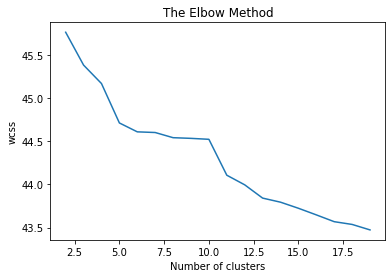

In [51]:
# YOUR CODE HERE
# Hint: Experiment with different range of clusters until a rapid decline is found at a point. for eg: (2, 20)
from sklearn.cluster import KMeans
wcss = []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(2,20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

### 2 Marks - > Train the k-Means model with the arrived optimal number of clusters.

1. Initialize the k-Means with optimal K value.
2. Fit the k-Means model with the feature vectors.
3. Predict the labels (i.e., clusters) of the feature vectors. 
4. Add the predicted labels to the existing train dataframe.

In [51]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=11 , init='k-means++', random_state= 42) #k-means++ to avoid random initializtion class
y_pred_kmeans = kmeans.fit_predict(X) # return similar in each group of dependent variable

In [59]:
# pickle the model
from sklearn.externals import joblib
joblib.dump(kmeans,  'abstract_clusters.pkl')

['abstract_clusters.pkl']

In [60]:
# extract list clusters
clusters = kmeans.labels_.tolist()

In [81]:
# assign each cluster to corresponding abastract
abstract_df[['cluster']] = clusters

In [63]:
#number of abstracts per cluster (clusters from 0 to 10)
abstract_df['cluster'].value_counts() 


6     1694
2     1199
4     1094
7      730
5      476
10      10
1        5
3        1
9        1
8        1
0        1
Name: cluster, dtype: int64

In [67]:
print(y_pred_kmeans) # dependent variable of K-means

[6 6 7 ... 2 4 2]


In [68]:
y_hat = kmeans.predict(X)

In [69]:
len(y_hat)

5212

In [70]:
abstract_df[['y_hats']] = y_hat

In [71]:
print(list(abstract_df))


['Program Title', 'Funding Organization', 'PI Name', 'Funding Amount - 2015 and later only', 'Abstracts', 'words', 'token_meaningful', 'token_processed', 'token_meaningful_alpha', 'abstract_lemmatized', 'lemmatized_processed', 'y_hats', 'cluster']


In [57]:
abstract_df.to_csv('processed_data.csv')

In [80]:
# Multidimensional scaling 
import os  # for os.path.basename
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
 #fit the vectorizer to Abstracts
%time tfidf_matrix = vectorizer.fit_transform(abstract_df.lemmatized_processed)
dist = 1 - cosine_similarity(tfidf_matrix)

MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
# shape (n_components, n_samples)
pos = mds.fit_transform(dist)  
xs, ys = pos[:, 0], pos[:, 1]
print()
print()

CPU times: user 1.06 s, sys: 8.85 ms, total: 1.07 s
Wall time: 1.08 s




In [88]:
# # Visualizing 11 abastract clusters

#set up colors per clusters using a dict
cluster_colors = {0: '#F0F8FF', 1: '#FFE4C4', 2: '#0000FF', 3: '#FFF8DC', 4: '#8B008B', \
                  5: '#00FF00', 6: '#FF0000', 7: '#FFFFFF', 8: '#FFFF00', 9: '#800080', \
                  10: '#1E90FF'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3', 
                 3: 'Cluster 4', 
                 4: 'Cluster 5',
                 5: 'Cluster 6', 
                 6: 'Cluster 7', 
                 7: 'Cluster 8', 
                 8: 'Cluster 9',
                 9: 'Cluster 10', 
                 10: 'Cluster 11', }



In [89]:
list(abstract_df)

['Program Title',
 'Funding Organization',
 'PI Name',
 'Funding Amount - 2015 and later only',
 'Abstracts',
 'words',
 'token_meaningful',
 'token_processed',
 'token_meaningful_alpha',
 'abstract_lemmatized',
 'lemmatized_processed',
 'y_hats',
 'cluster']

In [92]:
list(df_visualize)

['x', 'y', 'label', 'title']

Font 'default' does not have a glyph for '\x80' [U+80], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\x9c' [U+9c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\x9d' [U+9d], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\x82' [U+82], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\x80' [U+80], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\x9c' [U+9c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\x9d' [U+9d], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\x82' [U+82], substituting with a dummy symbol.


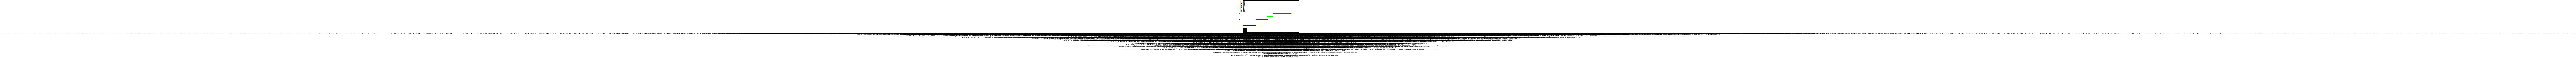

<Figure size 432x288 with 0 Axes>

In [96]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 
#create data frame that has the result of the abstract plus the cluster numbers and titles
df_visualize = pd.DataFrame(dict(x=xs, y=ys, label='clusters', title='Program Title')) 

#group by cluster
groups = abstract_df.groupby('cluster')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.Abstracts, group.y_hats, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_visualize)):
    ax.text(df_visualize.iloc[i]['x'], df_visualize.iloc[i]['y'], df_visualize.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_abstracts.png', dpi=200)

In [108]:
#!pip install mpld3
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [109]:
import mpld3
#create data frame that has the result of the abstract plus the cluster numbers and titles
df_visualize = pd.DataFrame(dict(x=xs, y=ys, label='clusters', title='Program Title'))  

#group by cluster
groups = df_visualize.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names.get('name'), mec='none', 
                     color=cluster_colors.get('name'))
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

No handles with labels found to put in legend.


In [ ]:
# Hierarchical abastracts clustering 
from scipy.cluster.hierarchy import ward, dendrogram
#define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(25, 30)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [111]:

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_visualize = pd.DataFrame(dict(x=xs, y=ys, label='clusters', title='Program Title'))  

#group by cluster
groups = df_visualize.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names.get('name'), mec='none', 
                     color=cluster_colors.get('name'))
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

No handles with labels found to put in legend.


### 4 Marks - > Visualize the top frequent words in any 2 clusters' abstracts, using a [word cloud](https://programmerbackpack.com/word-cloud-python-tutorial-create-wordcloud-from-text/) approach. 

#### This will allow you to identify the research areas in the different clusters, based on the most frequently occurring words

1. Combine all the abstracts of each chosen cluster.
2. Generate and display the word cloud of the chosen clusters.


In [115]:
#YOUR CODE HERE !pip install wordcloud
filterinfDataframe = abstract_df[(abstract_df['cluster'] == 6) | (abstract_df['cluster'] == 2) ]
filterinfDataframe.to_csv('sixth_second_clusters.csv')

In [116]:
#number of abstracts on clusters 6 and 2 
filterinfDataframe['cluster'].value_counts() 

6    1694
2    1199
Name: cluster, dtype: int64

In [121]:
# Generate and display the word cloud of the 6 and 2 clusters
from wordcloud import WordCloud
field = ['lemmatized_processed']
cluster_6_2_df = pd.read_csv('sixth_second_clusters.csv', usecols=field)


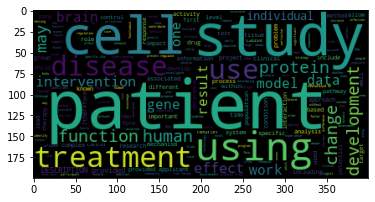

<Figure size 432x288 with 0 Axes>

In [127]:
wordcloud2 = WordCloud().generate(' '.join(cluster_6_2_df['lemmatized_processed']))
# Generate plot
plt.imshow(wordcloud2)
fig = plt.figure()
plt.show()

## **Stage 4:**  Deriving Insights


### 1 Mark - > List the PI names of each cluster

In [ ]:
# YOUR CODE HERE

### 2 Marks - > Predict the label (cluster) for the given search item



*   Get the vectors of the search item by transforming with TfidfVectorizer or Doc2Vec

*   Predict the label of the search item using k-Means model.

In [178]:
search_item = ["""Approximately 20 million people globally are infected with tuberculosis, and about 1.5 million people die of the disease annually, i.e. one death every 20 seconds. Currently, tuberculosis of the lungs is treated with four drugs ethambutol, isoniazid, rifampicin, and pyrazinamide daily for the first two months, followed by the two drugs isoniazid and rifampicin for the next four months. This drug combination is recommended by the World Health Organisation and is used in most countries of the world.
                The combination is highly effective if taken properly, but despite this about 15% patients worldwide are not cured. Factors such as patients not completing the course, missing multiple doses, or taking (or being prescribed) the wrong dose contribute to treatment failure. Although the drugs are free to patients, there is a substantial cost, in terms of time and administration, to both the patient and the treatment services. A recent study by Gospodarevskaya et al (Int J Tub Lung Dis. 18: 810-817) has found that patients have to terminate productive/economic activities and are often forced to borrow money and/or sell assets to cover cost of treatment, which can amount to more than three-quarters of patients' income, in the last 2 months of treatment. Reducing the duration of treatment should increase the number of people who successfully complete treatment and reduce the cost to them.
                A reduction could be achieved in one of two ways: using combinations of the new drugs currently under development, or by using the currently available drugs more effectively. Given the enormous cost and long time required to develop new drugs the second option is attractive. Increasing the dose of one of the currently available drugs may allow the duration of treatment to be shortened in the very near future.
                Three recently published Phase III trials (RIFAQUIN, ReMOX, OFLOTUB) have failed to demonstrate that treatment shortening can be achieved with the quinolones. hus, the rifamycins offer the best hope if higher doses can be shown to be safe.
                Rifampicin which is responsible for killing most tuberculosis bacteria, appears to be the best choice since increasing doses of rifampicin increases its ability to kill TB bacilli in vitro and animal studies. A similar result could be obtained in human tuberculosis. However, one concern would be a possible increase in unwanted serious side effects with increasing doses. Liver damage by rifampicin appears to be rare and not connected to dose size. In the RIFATOX Trial, a dose of 1200mg, in 100 patients did not increase its toxicity.
                The central question this trial aims to answer is therefore: does an increase in the dosage of rifampicin allow us to shorten treatment from 6 to 4 months? We are assessing whether giving double or triple the usual dose of rifampicin (1200mg, or 1800mg rather than 600mg daily) is safe and, when given for 4 months only, will result in relapse rates similar to (or better than) those found in the standard 6 month course of treatment. Patients with newly diagnosed tuberculosis of the lung, who agree to participate and have signed a consent form, will receive either the standard 6 month treatment or a 4 month treatment containing the standard drugs but with a double or triple dose of rifampicin. Treatment allocation will be random. The success of treatment in each method will be closely monitored both clinically and by regular microscopic examination of sputum, and the safety of the increased dose of rifampicin will be monitored clinically and with blood tests.
                If the trial is successful, it will lead to a shorter treatment course for pulmonary tuberculosis. The expected consequences would be: more patients completing the course and higher rates of cure, reduction in rates of transmission of tuberculosis with fewer people becoming infected, a reduced cost of treatment for both patients and treatment facilities and, perhaps, a reduction in the emergence of bacterial drug resistance.
                """]

In [159]:
import re
test_list = ' '.join([re.sub('[^a-zA-Z]+', ' ', _) for _ in search_item])

In [160]:
STOPWORDS = set(stopwords.words('english'))
test_str =  ' '.join([word for word in test_list.split() if word not in STOPWORDS]) # delete stopwords from text

In [161]:
test_str

'Approximately million people globally infected tuberculosis million people die disease annually e one death every seconds Currently tuberculosis lungs treated four drugs ethambutol isoniazid rifampicin pyrazinamide daily first two months followed two drugs isoniazid rifampicin next four months This drug combination recommended World Health Organisation used countries world The combination highly effective taken properly despite patients worldwide cured Factors patients completing course missing multiple doses taking prescribed wrong dose contribute treatment failure Although drugs free patients substantial cost terms time administration patient treatment services A recent study Gospodarevskaya et al Int J Tub Lung Dis found patients terminate productive economic activities often forced borrow money sell assets cover cost treatment amount three quarters patients income last months treatment Reducing duration treatment increase number people successfully complete treatment reduce cost A

In [163]:
new_test_string = ' '.join([w for w in test_str.split() if len(w)>1])


In [164]:
new_test_string

'Approximately million people globally infected tuberculosis million people die disease annually one death every seconds Currently tuberculosis lungs treated four drugs ethambutol isoniazid rifampicin pyrazinamide daily first two months followed two drugs isoniazid rifampicin next four months This drug combination recommended World Health Organisation used countries world The combination highly effective taken properly despite patients worldwide cured Factors patients completing course missing multiple doses taking prescribed wrong dose contribute treatment failure Although drugs free patients substantial cost terms time administration patient treatment services recent study Gospodarevskaya et al Int Tub Lung Dis found patients terminate productive economic activities often forced borrow money sell assets cover cost treatment amount three quarters patients income last months treatment Reducing duration treatment increase number people successfully complete treatment reduce cost reducti

In [167]:
def Convert(string): 
    li = list(string.split(" ")) 
    return li

In [172]:
new_test_list = Convert(new_test_string)
len(new_test_list)

373

In [184]:
# YOUR CODE HERE
# Extract feature vectors of the abstracts using TF-IDF 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df= 0.01, binary= True, norm= 'l1')
fit_X = vectorizer.fit_transform(new_test_list)
print(vectorizer.get_feature_names())
print(X.shape)

['cost', 'course', 'currently', 'dose', 'doses', 'drugs', 'increase', 'mg', 'months', 'one', 'patients', 'people', 'rifampicin', 'the', 'treatment', 'tuberculosis']
(373, 16)


In [175]:
# Load the model
kmeans = joblib.load('abstract_clusters.pkl')


In [ ]:
#Predict the label of the search item using k-Means model.
y_predict = kmeans.predict(fit_X)

### 2 Marks - > Find the top-10 corresponding **PI Names** from the predicted cluster, which are most relevant to the given search item.

Step 1 : Get the feature vectors of the documents (abstracts) of the above predicted cluster.
      
Hint: Use the indices of the documents that belong to the predicted cluster and get their feature vectors.

Step 2 : Calculate the distance between **search item feature vector** and **predicted cluster feature vectors**.

Hint: Use cdist from scipy for calculating the distance.


Step 3 : Find the top 10 feature vectors that have the least distance from the search item feature vector.

Step 4 : Give the PI Names corresponding to the top 10 feature vectors.

In [ ]:
# YOUR CODE HERE

### (Optional): Identify the top funded research investigators most relevant to the search item

In [ ]:
# YOUR CODE HERE